In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models,datasets
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # randomly rotate image +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # randomly flip left-right 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop to 224x224 at center
    transforms.ToTensor(),              # convert image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225]) # ImageNet std
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
root = r"C:\Users\admin\Downloads\Cat-Dog_Pandas-20251007T091050Z-1-001\Cat-Dog_Pandas"

In [8]:
train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=test_transform)

In [9]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog', 'panda']
Training images available: 2100
Testing images available:  600


In [10]:
ResNet18model = models.resnet18(pretrained=True)

In [11]:
ResNet18model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
for param in ResNet18model.parameters():
    param.requires_grad = False  # freeze all convolutional layers

num_features = ResNet18model.fc.in_features  # 512 for ResNet18

ResNet18model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)   # 3 classes: cat, dog, panda
)

In [13]:
ResNet18model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
for param in ResNet18model.parameters():
    print(param.numel())

9408
64
64
36864
64
64
36864
64
64
36864
64
64
36864
64
64
73728
128
128
147456
128
128
8192
128
128
147456
128
128
147456
128
128
294912
256
256
589824
256
256
32768
256
256
589824
256
256
589824
256
256
1179648
512
512
2359296
512
512
131072
512
512
2359296
512
512
2359296
512
512
131072
256
768
3


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18model.fc.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the device
ResNet18model = ResNet18model.to(device)

Using device: cuda


In [16]:
import time
import torch

# ----------------------------
# Parameters
# ----------------------------
epochs = 3 # because 3 gives better accuracy than 5
max_trn_batch = 800   # optional, can reduce for quick testing
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# ----------------------------
# Start timing
# ----------------------------
start_time = time.time()

# ----------------------------
# Training loop
# ----------------------------
for i in range(epochs):
    ResNet18model.train()   # set model to training mode
    trn_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break

        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        y_pred = ResNet18model(X_train)
        loss = criterion(y_pred, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute batch accuracy
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Print interim results
        if (b+1) % 200 == 0:
            print(f'epoch: {i+1:2}  batch: {b+1:4} [{(b+1)*10:6}/2100]  '
                  f'loss: {loss.item():10.8f}  '
                  f'accuracy: {trn_corr.item()*100/((b+1)*train_loader.batch_size):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # ----------------------------
    # Validation loop
    # ----------------------------
    ResNet18model.eval()   # set model to evaluation mode
    tst_corr = 0

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            X_test, y_test = X_test.to(device), y_test.to(device)

            y_val = ResNet18model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

        loss_val = criterion(y_val, y_test)
        test_losses.append(loss_val.item())
        test_correct.append(tst_corr.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  1  batch:  200 [  2000/2100]  loss: 0.44460702  accuracy:  87.050%
epoch:  2  batch:  200 [  2000/2100]  loss: 0.01885595  accuracy:  92.100%
epoch:  3  batch:  200 [  2000/2100]  loss: 0.00700092  accuracy:  92.600%

Duration: 184 seconds


In [17]:
best_val_acc = 0.0  # initialize best validation accuracy

val_acc = tst_corr.item() / len(test_data)  # calculate validation accuracy
if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(ResNet18model.state_dict(), 'best_resnet18_model.pth')
    print(f"Saved best model at epoch {i+1} with val_acc = {val_acc*100:.2f}%")

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Saved best model at epoch 3 with val_acc = 74.00%

Duration: 223 seconds


In [18]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]*100/len(test_data):.3f}%')

[437, 439, 444]
Test accuracy: 74.000%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


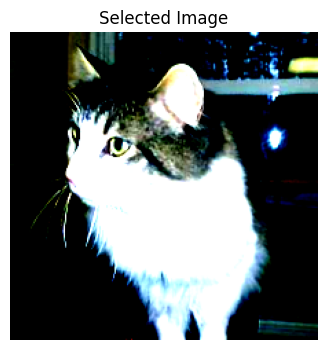

True class: cat
Predicted class: cat


In [27]:
image_index = 123
img, label = test_data[image_index]

# Convert tensor shape from [C,H,W] to [H,W,C] for plotting
plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title("Selected Image")
plt.show()

# Evaluate model
ResNet18model.eval()
with torch.no_grad():
    img_input = img.unsqueeze(0).to(device)
    pred = ResNet18model(img_input).argmax(dim=1)

predicted_class = class_names[pred.item()]
true_class = class_names[label]

print(f"True class: {true_class}")
print(f"Predicted class: {predicted_class}")

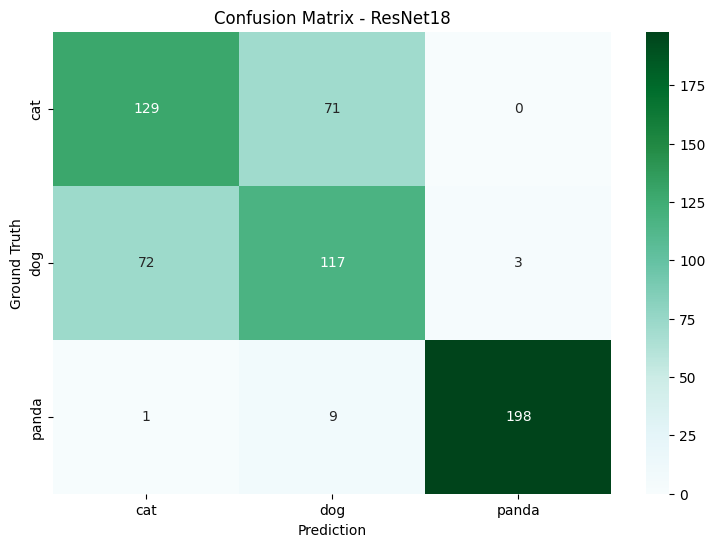

In [28]:
test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

all_preds = []
all_labels = []

ResNet18model.eval()
with torch.no_grad():
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = ResNet18model(X_test)
        predicted = torch.max(y_val, 1)[1]

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Compute confusion matrix
import seaborn as sns
arr = confusion_matrix(all_labels, all_preds)

# Optional: use your class names here if available
# Example:
# class_names = ['cat', 'dog', 'panda']

df_cm = pd.DataFrame(arr, index=class_names, columns=class_names)

plt.figure(figsize=(9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix - ResNet18")
plt.show()

In [29]:
torch.save(ResNet18model.state_dict(), "resnet18_catdogpanda.pth")

print("Model saved as resnet18_catdogpanda.pth")

Model saved as resnet18_catdogpanda.pth
